In [110]:
!pip install keras
!pip install tensorflow
!pip install numpy
!pip install matplotlib

In [1]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Resizing
from keras.metrics import CosineSimilarity
from keras.metrics import BinaryAccuracy
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def normalize_pixels(image):
    """normalize pixels to be between 0 and 1"""

	# convert from integers to floats
    image_norm = image.astype('float32')
	# normalize to range -1 and 1
    image_norm = (image_norm - 127.5) / 127.5

	# return normalized images
    return image_norm

def de_normalize_pixels(image, _from = 0, _to = 1):
    """de-normalize pixels to be between 0 and 255"""

    # Normalize between 0 and 1
    image_de_norm = (image * 127.5) + 127.5

    # Normalize between 0 and 1
    image_de_norm = image_de_norm/255 

    # Normalize between _from and _to
    image_de_norm = (image_de_norm * (_to - _from)) + _from
    
    return image_de_norm

def load_image(path):
    """load image from path and convert to array"""

    img = load_img(path, target_size=(224, 224), interpolation='bilinear')
    x = img_to_array(img)
    x = normalize_pixels(x)
    x = np.expand_dims(x, axis=0)
    return x

def unison_shuffled_copies(a, b):
    """shuffle two arrays in unison"""

    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def pairwise_euclidean_distance(vects):
    x, y = vects
    return K.square(x - y)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

test_image_1 = load_image(r'./data/dataset/all_souls/all_souls_000002.jpg')
test_image_1_de = de_normalize_pixels(test_image_1, 0, 255)
print(np.min(test_image_1))
print(np.max(test_image_1))
print(np.min(test_image_1_de))
print(np.max(test_image_1_de))

-1.0
1.0
0.0
255.0


In [3]:
# Variables

DATA_PATH = './data/dataset'
DATA_TRAIN_SPLIT = 0.8
DATA_VALIDATION_SPLIT = 0.1
# The TEST split will be the remaining of the two splits

#amount_of_positive_pairs_per_class = 50

In [4]:
# Load images into arrays
import pathlib

data_dir = pathlib.Path(DATA_PATH)

image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.jpeg')) + list(data_dir.glob('*/*.png')))
print("Total amount of images: " + str(image_count))

folders = [x for x in data_dir.iterdir() if x.is_dir()]

img_array_data = []

for i, folder in enumerate(folders):
    img_array_data.append([])

    for j, img in enumerate(folder.iterdir()):
        img_array_data[i].append(load_image(img))

Total amount of images: 555


In [5]:
data = []
labels = []

# Create image pairs
def create_image_pairs(images):
    for i, array in enumerate(images):
        for j in range(len(array)):
            # True
            data.append([
                images[i][j], 
                images[i][np.random.randint(0, len(images[i]) - 1)]])
            labels.append(1)

            x_1 = np.random.randint(0, len(images) - 1)
            x_2 = np.random.randint(0, len(images[x_1]) - 1)

            # False
            data.append([
                images[i][j], 
                images[x_1][x_2]])
            labels.append(0)

create_image_pairs(img_array_data)

data = np.array(data)
labels = np.array(labels)

In [6]:
# Shuffle Dataset
data, labels = unison_shuffled_copies(data, labels)

show_amount = 10
print(data[:show_amount])
print(labels[:show_amount])

[[[[[[-0.43529412 -0.01960784  0.6627451 ]
     [-0.42745098 -0.00392157  0.6862745 ]
     [-0.4117647   0.00392157  0.6862745 ]
     ...
     [-0.44313726 -0.05098039  0.6       ]
     [-0.44313726 -0.05882353  0.6       ]
     [-0.45882353 -0.06666667  0.58431375]]

    [[-0.42745098  0.00392157  0.6784314 ]
     [-0.4117647   0.01176471  0.69411767]
     [-0.3882353   0.01176471  0.69411767]
     ...
     [-0.42745098 -0.03529412  0.62352943]
     [-0.43529412 -0.03529412  0.6156863 ]
     [-0.4509804  -0.05098039  0.6       ]]

    [[-0.4117647   0.01176471  0.7019608 ]
     [-0.40392157  0.02745098  0.70980394]
     [-0.38039216  0.02745098  0.7176471 ]
     ...
     [-0.41960785 -0.01176471  0.6392157 ]
     [-0.41960785 -0.01960784  0.6313726 ]
     [-0.42745098 -0.02745098  0.6156863 ]]

    ...

    [[ 0.06666667 -0.03529412 -0.34117648]
     [ 0.05882353 -0.03529412 -0.35686275]
     [ 0.02745098 -0.04313726 -0.3882353 ]
     ...
     [ 0.05098039  0.04313726 -0.34901962]
   

In [7]:
# Split data into train, validation, and test

train_split = int(DATA_TRAIN_SPLIT * len(data))
validation_split = train_split+int(DATA_VALIDATION_SPLIT * len(data))

print("TRAIN SPLIT: " + "0 - " + str(train_split) + " | " + str(train_split) + " | " + str(DATA_TRAIN_SPLIT*100) + '%')
print("VALIDATION SPLIT: " + str(train_split) + " - " + str(validation_split) + " | " + str(validation_split-train_split) + " | " + str(DATA_VALIDATION_SPLIT*100) + '%')
print("TEST SPLIT: " + str(validation_split) + " - " + str(len(data)) + " | " + str(len(data) - validation_split) + " | " + str(100 - DATA_TRAIN_SPLIT*100 - DATA_VALIDATION_SPLIT*100) + '%')

data_train = data[0:train_split]
data_validation = data[train_split:validation_split]
data_test = data[validation_split:]

labels_train = labels[0:train_split]
labels_validation = labels[train_split:validation_split]
labels_test = labels[validation_split:]

print("---")
print("Training Data Shape: " + str(data_train.shape))
print("Validation Data Shape: " + str(data_validation.shape))
print("Test Data Shape: " + str(data_test.shape))
print("---")
print("Training Labels Shape: " + str(labels_train.shape))
print("Validation Labels Shape: " + str(labels_validation.shape))
print("Test Labels Shape: " + str(labels_test.shape))

TRAIN SPLIT: 0 - 888 | 888 | 80.0%
VALIDATION SPLIT: 888 - 999 | 111 | 10.0%
TEST SPLIT: 999 - 1110 | 111 | 10.0%
---
Training Data Shape: (888, 2, 1, 224, 224, 3)
Validation Data Shape: (111, 2, 1, 224, 224, 3)
Test Data Shape: (111, 2, 1, 224, 224, 3)
---
Training Labels Shape: (888,)
Validation Labels Shape: (111,)
Test Labels Shape: (111,)


## Feature Extractor M1

In [8]:
input_shape = (224, 224, 3)

# embedding extractor
embedding_extractor = Sequential(name='embedding_extractor')
base_model = MobileNetV2(input_shape=(input_shape), include_top = False, weights='imagenet')
base_model.trainable = False
embedding_extractor.add(base_model)

embedding_extractor.add(GlobalAveragePooling2D())

embedding_extractor.summary()

# Input pair
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

# Output pair
encoded_image_1 = embedding_extractor(input_image_1)
encoded_image_2 = embedding_extractor(input_image_2)

# Model
feature_extraction_model = Model(inputs=[input_image_1, input_image_2], outputs=[encoded_image_1, encoded_image_2], name='feature_extractor')
feature_extraction_model.summary()

Model: "embedding_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
Model: "feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []         

## M3

In [119]:
distance_input = Input(1280)
distance_output = Dense(128, activation='relu')(distance_input)
distance_output = Dense(64, activation='relu')(distance_output)
distance_output = Dropout(0.2)(distance_output)
distance_output = Dense(1, activation='softmax')(distance_output)

classification_model = Model(inputs=distance_input, outputs=distance_output, name='classification_model')

In [120]:

BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0005
DECAY_RATE = 1e-5

# Inputs
inputs = [Input(input_shape), Input(input_shape)]

# Feature Extraction Model
feature_extractor_layer = feature_extraction_model(inputs)

# Distance layer LAMBDA
distance_layer = Lambda(pairwise_euclidean_distance)(feature_extractor_layer) 

# Classification Model
classification = classification_model(distance_layer)

# Full Model
model = Model(inputs=inputs, outputs=classification, name='model')

model.summary()

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE, decay=DECAY_RATE), 
    loss='binary_crossentropy', 
    metrics=[BinaryAccuracy()])

history = model.fit(
    [data_train[:, 0, 0], data_train[:, 1, 0]], 
    labels_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
    validation_data=([data_validation[:, 0, 0], data_validation[:, 1, 0]], labels_validation))

# evaluate
score = model.evaluate(
    [data_test[:, 0, 0], data_test[:, 1, 0]], 
    labels_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 feature_extractor (Functional)  [(None, 1280),      2257984     ['input_17[0][0]',               
                                 (None, 1280)]                    'input_18[0][0]']           

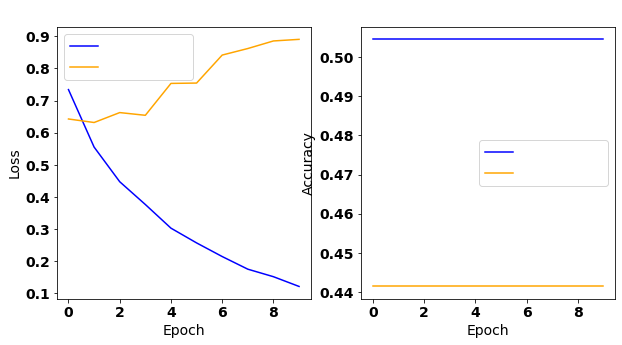

In [121]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['binary_accuracy'], color='blue', label='train')
	ax[1].plot(history.history['val_binary_accuracy'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(history)

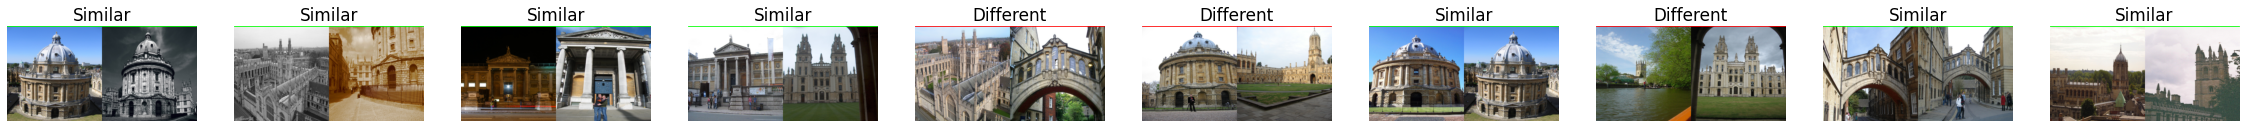

NameError: name 'model' is not defined

In [9]:
def visualize(pairs, labels, to_show=3, predictions=None):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    true_color = '#00ff00'
    false_color = '#ff0000'
    text_color = '#FFFFFF'
    scale = 2
    font_size = 14

    # Plot the images
    fig, axes = plt.subplots(1, to_show, figsize=(to_show*2*scale, 1*scale))

    plt.rcParams.update({'font.size': font_size, 'font.weight': 'bold', 'text.color': text_color})

    # Plot the pairs

    for i in range(to_show):
        axes[i].imshow((tf.concat([de_normalize_pixels(pairs[i, 0, 0]), de_normalize_pixels(pairs[i, 1, 0])], axis=1)), cmap='gray')

        status = "N/A"
        TP_FP_TN_FN = "N/A"
        color = '#000000'
        if labels[i] == 1: 
            status = "Similar"
            color = true_color
        if labels[i] == 0: 
            status = "Different"
            color = false_color

        axes[i].set_xticks([])
        axes[i].set_yticks([])

        axes[i].spines['top'].set_visible(True)
        axes[i].spines['top'].set_color(color)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)

        if predictions is not None:
            axes[i].set_title("{}\nPred: {:.5f}".format(status, predictions[i][0]))
        else:
            axes[i].set_title("{}".format(status))

    plt.show()

    # Plot true positives, false positives, true negatives, false negatives

visualize(data_train, labels_train, to_show=10)

visualize(data_test, labels_test, predictions=(model.predict([data_test[:, 0, 0], data_test[:, 1, 0]])), to_show=10)

In [10]:
from dataclasses import dataclass
from enum import Enum, auto

class Contingency(Enum):
    TP = auto()
    TN = auto()
    FP = auto()
    FN = auto()

@dataclass
class OutputSet:
    img1: np.ndarray
    img2: np.ndarray
    label: int
    prediction: int
    contingency: Contingency

@dataclass
class OutputSetDistance(OutputSet):
    distance: float

In [11]:
CORRECTION_FACTOR = 16

def get_distance_prediction(distance):
    if distance < CORRECTION_FACTOR:
        return 1
    else:
        return 0
    
def define_contingency(prediction, label):
    if prediction == 1 and label == 1:
        return Contingency.TP
    elif prediction == 1 and label == 0:
        return Contingency.TN
    elif prediction == 0 and label == 1:
        return Contingency.FP
    elif prediction == 0 and label == 0:
        return Contingency.FN
    else:
        raise ValueError("Invalid distance and label combination")

TRUE_CUTOFF = 0.7

def define_contingency2(prediction, label):
    if prediction > TRUE_CUTOFF and label == 1:
        return Contingency.TP
    elif prediction > TRUE_CUTOFF and label == 0:
        return Contingency.TN
    elif prediction <= TRUE_CUTOFF and label == 1:
        return Contingency.FP
    elif prediction <= TRUE_CUTOFF and label == 0:
        return Contingency.FN
    else:
        raise ValueError("Invalid distance and label combination")

def create_contingency_list(data, labels, predictions, has_distance=False):
    # feat = feature_extraction_model.predict([data[:, 0, 0], data[:, 1, 0]])
    # dist = euclidean_distance(feat)

    my_list = []

    for i in range(len(data)):
        img1 = data[i, 0, 0]
        img2 = data[i, 1, 0]
        label = labels[i]
        prediction = predictions[i]
        contingency = define_contingency2(prediction, label)

        my_list.append(OutputSet(img1, img2, label, prediction, contingency))

    print("Length: " + str(len(my_list)))

    amount_of_TP = 0
    amount_of_TN = 0
    amount_of_FP = 0
    amount_of_FN = 0

    for i in range(len(my_list)):
        amount_of_TP += my_list[i].contingency == Contingency.TP
        amount_of_TN += my_list[i].contingency == Contingency.TN
        amount_of_FP += my_list[i].contingency == Contingency.FP
        amount_of_FN += my_list[i].contingency == Contingency.FN

    print("TP:", amount_of_TP)
    print("TN:", amount_of_TN)
    print("FP:", amount_of_FP)
    print("FN:", amount_of_FN)
    print("Recall: {:.3f}".format(amount_of_TP / (amount_of_TP + amount_of_FN)))
    print("Precision: {:.3f}".format(amount_of_TP / (amount_of_TP + amount_of_FP)))
    print("F1: {:.3f}".format(2 * amount_of_TP / (2 * amount_of_TP + amount_of_FP + amount_of_FN)))
    print("Accuracy: {:.3f}".format((amount_of_TP + amount_of_TN) / (amount_of_TP + amount_of_TN + amount_of_FP + amount_of_FN)))

    my_list.sort(key=lambda x: x.prediction, reverse=True)
    
    # filte my_list to only show Contingency.TP
    # my_list = [x for x in my_list if x.contingency == Contingency.TP]
    return my_list

def visualize_contingency_table(contingency_list, to_show = 10, offset = 0, has_distance = False):

    true_color = '#00ff00'
    false_color = '#ff0000'
    text_color = '#FFFFFF'
    scale = 2
    font_size = 14

    # Plot the images
    fig, axes = plt.subplots(1, to_show, figsize=(to_show*2*scale, 1*scale))

    plt.rcParams.update({'font.size': font_size, 'font.weight': 'bold', 'text.color': text_color})

    for i in range(to_show):
        index = i + offset

        axes[i].imshow((tf.concat([de_normalize_pixels(contingency_list[index].img1), de_normalize_pixels(contingency_list[index].img2)], axis=1)), cmap='gray')

        status = "N/A"
        color = '#000000'
        if contingency_list[index].label == 1: 
            status = "Similar"
            color = true_color
        if contingency_list[index].label == 0:
            status = "Different"
            color = false_color

        axes[i].set_xticks([])
        axes[i].set_yticks([])

        axes[i].spines['top'].set_visible(True)
        axes[i].spines['top'].set_color(color)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)

        title = ""
        title += status + "\n"
        if has_distance:
            title += "Distance: " + str(contingency_list[index].distance) + "\n"
        title += "Label: " + str(contingency_list[index].label) + "\n"
        title += "Prediction: " + str(contingency_list[index].prediction) + "\n"
        title += "Contingency: " + str(contingency_list[index].contingency.name)
        title += "\n"

        axes[i].set_title(title)

# dense_list = create_contingency_list(data_test, labels_test, model.predict([data_test[:, 0, 0], data_test[:, 1, 0]]))

# visualize_contingency_table(dense_list, to_show=10)

# contingency_list = create_contingency_list(data_test, labels_test)

# visualize_contingency_table(contingency_list, to_show=10, offset=0)

0.797105610370636


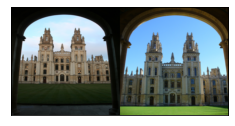

In [12]:
def visualize_image_pair(img1, img2, scale = 2):
    fig, axes = plt.subplots(1, 1, figsize=(1*2*scale, 1*scale))

    axes.set_xticks([])
    axes.set_yticks([])

    axes.imshow((tf.concat([de_normalize_pixels(img1[0]), de_normalize_pixels(img2[0])], axis=1)), cmap='gray')

def visualize_dataset_pair(dataset, index, scale = 2):
    img1 = dataset[index, 0, 0]
    img2 = dataset[index, 1, 0]

    visualize_image_pair(img1, img2, scale)

index = 1

cosine_similarity = CosineSimilarity()

test_image_1 = load_image("test_image_1.png")
test_image_2 = load_image("test_image_2.png")

test_image_3 = load_image(r'./data/dataset/all_souls/all_souls_000002.jpg')
test_image_4 = load_image(r'./data/dataset/all_souls/all_souls_000209.jpg')

visualize_image_pair(test_image_3, test_image_4)

feat = feature_extraction_model.predict([test_image_3, test_image_4])
dist = float(cosine_similarity(feat[0], feat[1]))

print(dist)
# create_contingency_list(data_test, labels_test, feature_extraction_model.predict([data_test[:, 0, 0], data_test[:, 1, 0]]))


(111, 1280)
(111, 1280)
Length: 111
TP: 0
TN: 0
FP: 50
FN: 61
Recall: 0.000
Precision: 0.000
F1: 0.000
Accuracy: 0.000


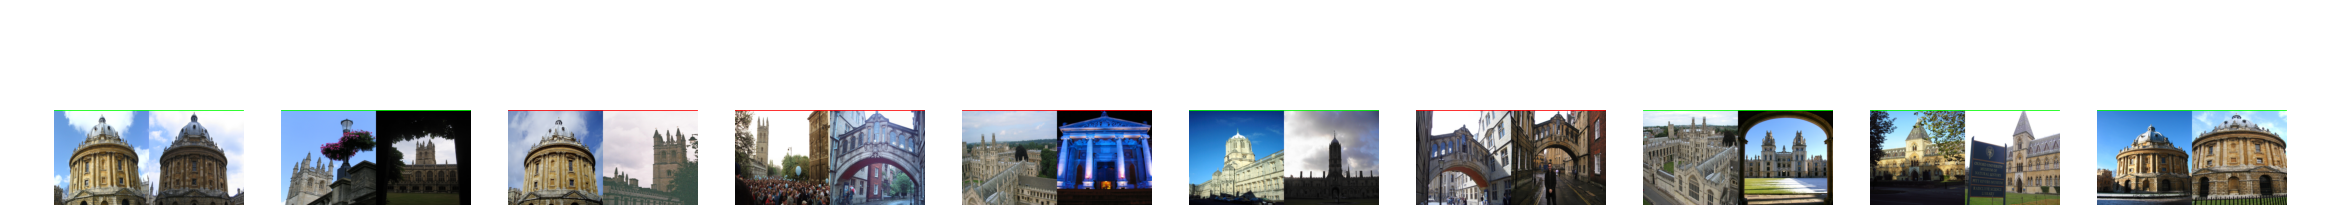

In [14]:
feat_all = feature_extraction_model.predict([data_test[:,0,0], data_test[:,1,0]])

# get the cosine similarity between all the images
cosine_similarity = CosineSimilarity()
dist_all = []

for i in range(len(feat_all[0])):
    dist_all.append(float(cosine_similarity(feat_all[0][i], feat_all[1][i])))

dist_all = np.array(dist_all)

con = create_contingency_list(data_test, labels_test, dist_all)
visualize_contingency_table(con, to_show=10)